In [1]:
#import necessary frameworks.
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from surprise.model_selection import train_test_split
from surprise import KNNWithMeans,KNNWithZScore, SVD, SlopeOne, SVDpp, NMF, NormalPredictor, KNNBaseline, KNNBasic,BaselineOnly, CoClustering
from surprise import Reader,Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
import math


In [2]:
# Load Electronics ratings data.
# Add column names.
e_commerce_data = pd.read_csv('ratings_Electronics.csv')
e_commerce_data.columns = ['userID','productID','rating','timestamp']

In [3]:
# Let's see how the data is present.
e_commerce_data.drop(columns=['timestamp'],inplace=True)
e_commerce_data.head()

,userID,productID,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [4]:
# Let's check shape of the data
print(f"Numeber of rows:{e_commerce_data.shape[0]} and number of cols:{e_commerce_data.shape[1]}")

Numeber of rows:7824481 and number of cols:3


In [5]:
e_commerce_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
userID       object
productID    object
rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [6]:
# Let's check any NaN value present in data.
e_commerce_data.isna().any()

userID       False
productID    False
rating       False
dtype: bool

In [7]:
e_commerce_data.rating.describe().T

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

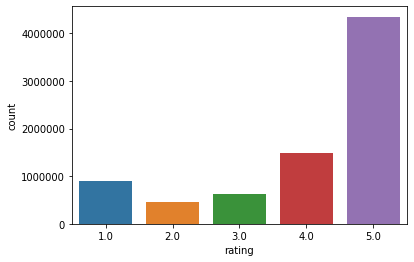

In [8]:
# Let's check distribution of userRatings
sns.countplot(e_commerce_data.rating)

In [9]:
e_commerce_data.groupby('userID')['rating'].count().sort_values(ascending=False)[0:50]
# here, I'm grouped by userID and taken top 50 ratings counts.

userID
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A3EXWV8FNSSFL6    282
A38RMU1Y5TDP9     282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
A2XRMQA6PJ5ZJ8    253
A231WM2Z2JL0U3    252
A12DQZKRKTNF5E    252
A1UQBFCERIP7VJ    247
AGVWTYW0ULXHT     244
A203OCQQ12MAVT    240
AEJAGHLC675A7     239
A2NYK9KWFMJV4Y    238
A3A4ZAIBQWKOZS    236
A3CW0ZLUO5X2B1    227
A1T1YSCDW0PD25    227
A31N0XY2UTB25C    227
A2UOHALGF2X77Q    227
A250AXLRBVYKB4    226
A4WEZJOIZIV4U     225
A1CMD08Z49PGKQ    221
A1VQHH85U7PX0     220
A1J75JJ0Q2OEJN    218
AOEAD7DPLZE53     218
A11KZ906QD08C5    216
A20DZX38KRBIT8    213
A1F9Z42CFF9IAY    213
AVPNQUVZWMDSX     212
A3OA4DV4L81N1D    209
A1EVV74UQYVKRY    208
A1E

In [10]:
print(f'Unique userId ids: {e_commerce_data.userID.nunique()}')
print(f'Unique productId ids: {e_commerce_data.productID.nunique()}')

Unique userId ids: 4201696
Unique productId ids: 476001


In [11]:
user_counts = e_commerce_data['userID'].value_counts()

In [12]:
len(user_counts[user_counts>=202])

51

In [13]:
# I am considering 200 ratings counts based on userID
filter_ = user_counts >= 200
filter_ = filter_[filter_].index.tolist()

In [14]:
# taking only those filtered information from original data.
new_e_commerce_data = e_commerce_data[e_commerce_data['userID'].isin(filter_)]

In [15]:
new_e_commerce_data.head()

,userID,productID,rating
2161,A5JLAU2ARJ0BO,1400532655,1.0
3382,A3PD8JD9L4WEII,1400699169,5.0
4613,A1VQHH85U7PX0,9043413585,3.0
5194,A36K2N527TXXJN,9800359788,5.0
5931,ADLVFFE4VBT8,9981719005,3.0


In [16]:
new_e_commerce_data.shape

(13862, 3)

In [17]:
# let's check number of unique firequently visited users
new_e_commerce_data.userID.nunique()

52

In [18]:
# let's check number of unique  products firequently visited by users
new_e_commerce_data.productID.nunique()

9673

# Popularity based Recommender system

In [19]:
# Define a class 'PopularityBasedRecommender'
class PopularityBasedRecommender:
    
    # initialize cunstructor with data.
    def __init__(self,data):
        self.data = data
    
    # Here create top 5 popular recommendations to user.
    def createTopRecommendations(self,no_recommedations=5):
        data_df = self.data.groupby('productID').agg({'userID':'count'}).reset_index()
        data_df.rename(columns={'userID':'userID_count'},inplace=True)
        
        data_df_sort = data_df.sort_values(['userID_count','productID'],ascending=[0,1])
        data_df_sort['rank'] = data_df_sort['userID_count'].rank(ascending=False,method='first')
        print('Bellow are the top {} recommendations:'.format(no_recommedations))
        print(data_df_sort.head(no_recommedations))

In [20]:
# Initialze class here.
PR = PopularityBasedRecommender(new_e_commerce_data)

In [21]:
PR.createTopRecommendations()

Bellow are the top 5 recommendations:
       productID  userID_count  rank
5266  B003ES5ZUU            17   1.0
2260  B000JMJWV2            16   2.0
5895  B004CLYEDC            15   3.0
4779  B002R5AM7C            14   4.0
7372  B007OY5V68            14   5.0


In [22]:
# Checking 
popular_items_df = new_e_commerce_data.groupby(['productID'])['rating'].count().sort_values(ascending=False).reset_index()
popular_items_df.head(5)


,productID,rating
0,B003ES5ZUU,17
1,B000JMJWV2,16
2,B004CLYEDC,15
3,B007OY5V68,14
4,B00829THK0,14


# Collabrative Filtering
### using surprise.BaselineOnly()

In [23]:
# check upper and lower ratings from data.
lower_rating = new_e_commerce_data.rating.min()
upper_rating = new_e_commerce_data.rating.max()
lower_rating,upper_rating

(1.0, 5.0)

In [24]:
# Convert the dataframe into dataset, shwich supports the surprise lib models.
# First define a reader, whcih intakes lower and upper ratings.
reader = Reader(rating_scale=(lower_rating, upper_rating))
df = new_e_commerce_data[['userID', 'productID', 'rating']]
print(df.head())
# Bys using load_from_df load the original data as a dataset with the help of reader.
data_df = Dataset.load_from_df(df, reader)

              userID   productID  rating
2161   A5JLAU2ARJ0BO  1400532655     1.0
3382  A3PD8JD9L4WEII  1400699169     5.0
4613   A1VQHH85U7PX0  9043413585     3.0
5194  A36K2N527TXXJN  9800359788     5.0
5931    ADLVFFE4VBT8  9981719005     3.0


In [25]:
# Devide the dataset into train and test.
train_data,test_data = train_test_split(data_df,test_size=0.15,random_state=42)

In [26]:
len(test_data)

2080

In [27]:
# the bellow code is used to check which model peroformase good based rmse using cross validate method,

In [28]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_df, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.932605,0.046804,0.039637
SVDpp,0.936627,35.316133,0.712990
SVD,0.936756,0.839131,0.048113
KNNBaseline,0.980562,0.050595,0.098282
KNNWithMeans,1.021788,0.011339,0.063986
KNNWithZScore,1.027453,0.018332,0.067918
SlopeOne,1.037534,1.759358,0.326491
CoClustering,1.041840,1.423883,0.041025
KNNBasic,1.051005,0.004707,0.088601


In [29]:
# As we can see, in the above dataframe.
# Whcih is sorted based on 'rmse' values.
# bases on this rmse value, I can say 'BaselineOnly' performance is good.
# And, I go head and build model.

In [30]:
model = BaselineOnly()
model.fit(train_data)

Estimating biases using als...


In [31]:
cross_validate(model, data_df,
               measures=['rmse'],
               cv=3, verbose=False,
               n_jobs=-1,
               return_train_measures=True)

{'test_rmse': array([0.93317286, 0.93824396, 0.92473708]),
 'train_rmse': array([0.84682158, 0.84389256, 0.8507389 ]),
 'fit_time': (0.03506827354431152, 0.031929969787597656, 0.03034806251525879),
 'test_time': (0.039067983627319336,
  0.03959083557128906,
  0.041136980056762695)}

In [32]:
test_pred = model.test(test_data)

In [33]:
test_pred[0:10]

[Prediction(uid='A23GFTVIETX7DS', iid='B0079TOEQQ', r_ui=5.0, est=4.4992465260358845, details={'was_impossible': False}),
 Prediction(uid='AGVWTYW0ULXHT', iid='B008X1BVH4', r_ui=4.0, est=3.975508594103089, details={'was_impossible': False}),
 Prediction(uid='A3OXHLG6DIBRW8', iid='B000QWG43Y', r_ui=5.0, est=4.509538015187333, details={'was_impossible': False}),
 Prediction(uid='A36K2N527TXXJN', iid='B003M0NT1M', r_ui=5.0, est=4.4279045090969005, details={'was_impossible': False}),
 Prediction(uid='A203OCQQ12MAVT', iid='B000AZJ268', r_ui=4.0, est=4.44400847053451, details={'was_impossible': False}),
 Prediction(uid='A203OCQQ12MAVT', iid='B0009KF9BQ', r_ui=1.0, est=4.44400847053451, details={'was_impossible': False}),
 Prediction(uid='A231WM2Z2JL0U3', iid='B00006JHTQ', r_ui=4.0, est=4.32426144905868, details={'was_impossible': False}),
 Prediction(uid='A3OXHLG6DIBRW8', iid='B002RWJGTU', r_ui=5.0, est=4.453580716114752, details={'was_impossible': False}),
 Prediction(uid='A4WEZJOIZIV4U', i

In [34]:
accuracy.rmse(test_pred)

RMSE: 0.9311


0.9310853471817272

In [35]:
model.predict('A23GFTVIETX7DS','B0079TOEQQ')

Prediction(uid='A23GFTVIETX7DS', iid='B0079TOEQQ', r_ui=None, est=4.4992465260358845, details={'was_impossible': False})

### using scipy.sparse.linalg.svds()

#### Preprocessing data

In [36]:
# Prepare pivot dataframe from 'new_e_commerce_data'.
# 'new_e_commerce_data' is a dataframe, where it consists only users who have more than 290 counts.
final_rating_matrix = new_e_commerce_data.pivot(index='userID',columns='productID',values='rating').fillna(0)

In [37]:
# pivot dataframe
final_rating_matrix.head()

productID,1400532655,1400699169,9043413585,9800359788,9981719005,998376234X,B000001OMI,B000001ON0,B00000DM9M,B00000DM9W,...,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LGQ6HL8,B00LI4ZZO8
userID,,,,,,,,,,,,,,,,,,,,,
A11I1I9QLMAM1A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11KZ906QD08C5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A17BUUBOU0598B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CMD08Z49PGKQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
final_rating_matrix.shape

(52, 9673)

In [39]:
final_df = final_rating_matrix.copy(True)

In [40]:
# Replace index column from 'userID' to 'user_index' numerical type
final_df['user_index'] = np.arange(0,final_df.shape[0],1)
final_df.set_index(['user_index'],inplace=True)

In [41]:
final_df.head()

productID,1400532655,1400699169,9043413585,9800359788,9981719005,998376234X,B000001OMI,B000001ON0,B00000DM9M,B00000DM9W,...,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LGQ6HL8,B00LI4ZZO8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### -----------------

In [42]:
from scipy.sparse.linalg import svds

In [43]:
# prepare 'UBCollabrativeFilter' class.
class UBCollabrativeFilter:
    
    def __init__(self,actual_df):
        self.actual_df = actual_df
        
    # To check the sparsity of the matrix
    def checkSparsityOfData(self):
        number_of_nozero_ratings = np.count_nonzero(self.actual_df)
        sparsity = (1 - number_of_nozero_ratings / self.actual_df.size ) * 100
        print('Num of non zero values: {}'.format(number_of_nozero_ratings))
        print('Size of data: {}'.format(self.actual_df.size))
        print('sparsity of the data is: {}%'.format(np.round(sparsity,2)))
    
    # To get the predicated rating for zero-ratings.
    def getPredRatings(self):
        pred_ratings_df = self.__svd_()
        return pred_ratings_df
       
    # Calcualte SVD using actual data.
    def __svd_(self):
        # 'k' value should be between 1 and 'min(actual.shape)'.
        k = min(self.actual_df.shape)
        u,sigma,vt = svds(self.actual_df,k=k-1)
        # Convert single D sigma to diagonal matrix.
        sigma = np.diag(sigma)
        # get dot product of u,sigma and vt.
        pred_ratings_df = self.__dotProductAndPrepareDF(u,sigma,vt)
        return pred_ratings_df
    
    # prepare dataframe from dot product of u, sigma and vt.
    def __dotProductAndPrepareDF(self,u,sigma,vt):
        pred_ratings_df = pd.DataFrame(np.dot(np.dot(u,sigma),vt),columns=self.actual_df.columns)
        return pred_ratings_df
    
    # This method takes userId pred_df and no_recommendation as params.
    # pred_df: is predicted ratings.
    # no_recmmendation: is the count to show recommedations.
    def recommendationUB(self,userId,pred_df,no_recmmendation):
        # Here, reduce user_idx by one.
        user_idx = userId-1
        # get sorted actual ratings from actual df in Descending order.
        sorted_actual_ratings = self.actual_df.iloc[user_idx].sort_values(ascending = False)
        # get sorted pred ratings from pred df in Descending order.
        sorted_pred_ratings = pred_df.iloc[user_idx].sort_values(ascending = False)
        # concat actual and pred sorted ratings.
        concat_df = pd.concat([sorted_actual_ratings,sorted_pred_ratings],axis=1)
        concat_df.index.name = ['productID']
        concat_df.columns = ['user_ratings','predicted_ratings']
        # Filter concat df based on user_rating where 'user_ratings' has '0.0' ratings.
        # Sort the filtered concat df based 'predicted_ratings'  in descending order.
        concat_df = concat_df[concat_df.user_ratings == 0].sort_values('predicted_ratings',ascending = False)
        print(concat_df.head(no_recmmendation))
        mse_score = mean_squared_error(concat_df['user_ratings'],concat_df['predicted_ratings'])
        rmse_score = math.sqrt(mse_score)
        print('RMSE score: {}'.format(np.round(rmse_score,4)))
    

In [44]:
# Initialize the 'UBCollabrativeFilter' class with passing 'final_df'.
ubCollabFilterObj = UBCollabrativeFilter(final_df)

In [45]:
# As we can see the matrix is sparsed.
ubCollabFilterObj.checkSparsityOfData()

Num of non zero values: 13862
Size of data: 502996
sparsity of the data is: 97.24%


In [46]:
# Get the prepdicated ratings by calling the 'getPredRatings()' method.
predicted_ratings = ubCollabFilterObj.getPredRatings()

In [47]:
predicted_ratings.head()

productID,1400532655,1400699169,9043413585,9800359788,9981719005,998376234X,B000001OMI,B000001ON0,B00000DM9M,B00000DM9W,...,B00L21HC7A,B00L2442H0,B00L26YDA4,B00L2P3TRS,B00L3YHF6O,B00L43HAY6,B00L8I6SFY,B00LA6T0LS,B00LGQ6HL8,B00LI4ZZO8
0,0.000035,0.000046,0.000246,0.000359,-0.000316,0.000237,-0.000447,-0.000899,-0.000339,0.000906,...,-0.000284,0.000160,0.000598,-0.000149,-0.000310,-0.000457,-0.000151,-0.000270,-0.000879,-0.000817
1,-0.000048,-0.000063,-0.000339,-0.000495,0.000435,-0.000326,0.000616,0.001237,0.000467,-0.001247,...,0.000390,-0.000220,-0.000823,0.000205,0.000427,0.000628,0.000208,0.000371,0.001210,0.001125
2,-0.000018,-0.000024,-0.000129,-0.000189,0.000166,-0.000124,0.000235,0.000472,0.000178,-0.000476,...,0.000149,-0.000084,-0.000314,0.000078,0.000163,0.000240,0.000079,0.000142,0.000461,0.000429
3,-0.000054,-0.000071,-0.000378,-0.000552,0.000485,-0.000364,0.000687,0.001382,0.000521,-0.001392,...,0.000436,-0.000245,-0.000919,0.000229,0.000476,0.000701,0.000232,0.000415,0.001351,0.001256
4,0.000019,0.000025,0.000132,0.000193,-0.000169,0.000127,-0.000240,-0.000482,-0.000182,0.000486,...,-0.000152,0.000086,0.000320,-0.000080,-0.000166,-0.000245,-0.000081,-0.000145,-0.000471,-0.000438


In [48]:
# below are the top 5 recommendation for given user.
user_id = 12
no_recommedations = 5
ubCollabFilterObj.recommendationUB(user_id,predicted_ratings,no_recommedations)

             user_ratings  predicted_ratings
[productID]                                 
B002JSS2NS            0.0           0.066436
B000065SP7            0.0           0.066217
B000DZDPJA            0.0           0.066217
B000K1KTNW            0.0           0.066217
B006THMCH2            0.0           0.066217
RMSE score: 0.0062
